# Crime In Detroit (2009 to 2015)

#### Course: Data Bootcamp <br/> Name: Gillian Berberich <br/> Project Date: May 4th, 2016 <br/> New York University <br/> Leonard N. Stern School of Business

This project examines crime data in Detroit, Michigan from January 1, 2009 to December 31, 2015 using [Detroit Open Data](https://data.detroitmi.gov/). There are several datasets of interest contained on the Detroit Open Data website. The main crime file has over 1 million records and is updated frequently. Other datasets used contain locational data for schools, police stations, and fire stations within Detroit city limits.

**Research Questions:**
* Has crime increased, decreased, or stayed the same over the last 6 years?
* Is crime level consistent over different times of day? Is this affected by specific offense?
* Is the crime pattern over the last 6 years consistent over all neighborhoods?
* What is the distribution of crime location relative to institution (police stations, fire stations, schools) location?

# 1.0 Importing Packages

For this project, I have used several packages available in Python. It is useful to know which versions I am using as well as the date these scripts were run.

In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import numpy as np              # numpy package
import sys                      # system module, used to get Python version 
import geopy as geo             # geographical package
import seaborn as sns           # seaborn package
import datetime as dt           # date tools, used to note current date

%matplotlib inline 

print('\nPython version: ', sys.version) 
print('Pandas version: ', pd.__version__)
print('Numpy version: ', np.__version__)
print('Geopy version: ', geo.__version__)
print('Seaborn version: ', sns.__version__)
print("Today's date:", dt.date.today())


Python version:  3.5.1 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:49:46) [MSC v.1900 64 bit (AMD64)]
Pandas version:  0.18.0
Numpy version:  1.10.4
Geopy version:  1.11.0
Seaborn version:  0.7.0
Today's date: 2016-05-06


# Reading Data

The datasets can be accessed live from [Detroit Open Data](https://data.detroitmi.gov/) in the json format. Each data file contains a link which explains how to access the data (each dataset provides a link, shown as url, url1, url2, url3 below). For one of the datasets, a link was not available, though I was able to create a link by finding the resource number for the data. 

Follow these instructions to access the data:
 
* Open the web address https://data.detroitmi.gov/
* Click “Public Safety”
* Locate “DPD: All Crime Incidents, 2009 – Present (Provisional)” on the list.
* Click “API Docs” link to the bottom right of that block.
* Scroll down to “Getting Started” and you will see a link that ends in .json
* Copy the link, this is the link that IPython will pull the data from.
* Repeat process for “DPD Stations” and “DFD Stations”
 
Follow these instructions to access the Detroit School data.
* Click the “Education” link on the left hand bar under “Categories”.
* Locate “Detroit Schools” on the list.
* Click on the dataset.
* On the bar at the top right, click “Export”
* Under “Download as”, right click on “JSON” and click “Copy Link Location”
* Paste the link to a word document and copy the resource code portion (it is 4 characters followed by a hyphen and four more characters).
* Add this resource code to the end of  https://data.detroitmi.gov/resource/
* Finally, add .json to the end of it. This is the link that IPython will pull data from.

We can use query information from [Socrata](https://dev.socrata.com/docs/queries/) to pull only the data we will use. This makes the requests much faster.

### 1.1 Reported Crimes from Detroit Open Data

Uploading the data directly from Detroit Crime Data. 

**Note:** This code takes a very long time to run and may time out depending on your system's available memory. If you are running this code, you must remove the # marks.

In [2]:
# url = ('https://data.detroitmi.gov/resource/i9ph-uyrp.json?'
#       '&$select=caseid,address,hour,incidentdate,lat,lon,neighborhood,category,offensedescription'
#       '&$limit=1200000')

# crime = pd.read_json(url)                           # reads in file from url in json format
# crime = crime.rename(columns={'caseid':'Case ID',   # renaming the columns
#                              'address':'Address',
#                              'hour':'Hour',
#                              'incidentdate':'Incident Date',
#                              'lat':'Latitude',
#                              'lon':'Longitude',
#                              'neighborhood':'Neighborhood',
#                              'category':'Category',
#                              'offensedescription':'Offense Description'})

# crime.head(2)

,Address,Case ID,Category,Hour,Incident Date,Latitude,Longitude,Neighborhood,Offense Description
0,11400 WHITCOMB,2062789,FRAUD,0,2016-01-01T00:00:00.000,42.3716,-83.1948,PLYMOUTH-HUBBELL,FRAUD (OTHER)
1,00 E 7 MILE CARDONI,2037998,ROBBERY,0,2016-01-01T00:00:00.000,42.4326,-83.0916,STATE FAIR-NOLAN,ROBBERY - STREET - GUN


### 1.2 Reported Crimes from File

Instead, I will pull the file from my harddrive, which takes much less time and is more reliable.

In [3]:
crime = pd.read_csv('DPD__All_Crime_Incidents__2009_-_Present__Provisional.csv') # Read the file from my harddrive
print('Original Dimensions:', crime.shape)                                       # Provides dataset dimensions

crime = crime.rename(columns={'CASEID':'Case ID',                                # Renaming the columns
                              'ADDRESS':'Address',
                              'HOUR':'Hour',
                              'INCIDENTDATE':'Incident Date',
                              'LAT':'Latitude',
                              'LON':'Longitude',
                              'NEIGHBORHOOD':'Neighborhood',
                              'CATEGORY':'Category',
                              'OFFENSEDESCRIPTION':'Offense Description'})

# Uses only the columns we need to examine this dataset.
crime = crime[['Case ID','Longitude','Latitude','Address','Incident Date','Hour','Neighborhood','Category','Offense Description']].set_index('Case ID')

print('New Dimensions:', crime.shape)                                           # Dimensions for new dataset (fewer columns)
crime.head(2)

C:\Users\Jill\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original Dimensions: (1048575, 18)
New Dimensions: (1048575, 8)


,Longitude,Latitude,Address,Incident Date,Hour,Neighborhood,Category,Offense Description
Case ID,,,,,,,,
1099487,-83.0649,42.4261,18000 WEXFORD,1/1/2009,0,CONANT GARDENS,MISCELLANEOUS,MISCELLANEOUS - GENERAL NON-CRIMINAL
1117507,999999.0001,999999.0000,00 UNKNOWN,1/1/2009,0,NaN,MISCELLANEOUS,MISCELLANEOUS - GENERAL NON-CRIMINAL


### Police Station Locations

The police station file is small enough that it can be uploaded directly from the website. This file contains locational information for all police stations in Detroit.

In [4]:
url1 = 'https://data.detroitmi.gov/resource/3n6r-g9kp.json'
police = pd.read_json(url1)
police = police.rename(columns={'address_1':'Address',         # Rename columns
                                'zip_code':'Zip Code',
                                'id':'ID'})

police.insert(1, 'Longitude', 0.0)                # Inserts a column in the dataframe for longitude
police.insert(2, 'Latitude', 0.0)                 # Inserts a column in the dataframe for latitude

for (i, ps) in police.iterrows():                 # Iteration for one row at a time of the dataframe
    curr_dict = ps['location']                    # Pulls out dictionary from cell containing coordinates
    coord = curr_dict['coordinates']              # Pulls out coordinates from dictionary

    police.set_value(i, 'Longitude', coord[0])    # Places the first value in the dictionary in Longitude
    police.set_value(i, 'Latitude', coord[1])     # Places the second value in the dictionary in Latitude

# Sets the index to ID and uses only columns we need
police = police[['ID','Longitude','Latitude','Address','Zip Code']].set_index('ID')

police.head(2)

,Longitude,Latitude,Address,Zip Code
ID,,,,
1,-83.045241,42.326325,20 Atwater,48226
2,-83.179933,42.385553,13530 Lesure,48227


### 1.3 Fire Station Locations

The fire station file is also small enough that it can be uploaded directly from the website. This file contains locational information for all fire stations in Detroit.

In [5]:
url2 = 'https://data.detroitmi.gov/resource/hz79-58xh.json'
fire = pd.read_json(url2)
fire = fire.rename(columns={'station':'Station',               # Rename columns
                            'full_address_address':'Address',
                            'full_address_zip':'Zip Code'})

fire.insert(1, 'Longitude', 0.0)                 # Inserts a column in the dataframe for longitude
fire.insert(2, 'Latitude', 0.0)                  # Inserts a column in the dataframe for latitude

for (i, fs) in fire.iterrows():                  # Iteration for one row at a time of the dataframe
    curr_dict = fs['full_address']               # Pulls out dictionary from cell containing coordinates
    coord = curr_dict['coordinates']             # Pulls out coordinates from dictionary

    fire.set_value(i, 'Longitude', coord[0])     # Places the first value in the dictionary in Longitude
    fire.set_value(i, 'Latitude', coord[1])      # Places the second value in the dictionary in Latitude

# Sets the index to ID and uses only columns we need
fire = fire[['Station','Longitude','Latitude','Address','Zip Code']].set_index('Station')

fire.head(2)

,Longitude,Latitude,Address,Zip Code
Station,,,,
E50,-82.985474,42.420406,12985 Houston Whittier St,48205
E42,-83.138740,42.366575,6324 W Chicago,48204


### 1.4 School Locations

The school file is also small enough that it can be uploaded directly from the website. This file contains locational information for all schools in Detroit.

In [6]:
url3 = 'https://data.detroitmi.gov/resource/8xpr-6ij9.json'
school = pd.read_json(url3)
school = school.rename(columns={'entityoffi':'School',        # Rename columns
                                'the_geom':'Location',
                                'entityphys':'Address',
                                'entityph_4':'Zip Code'})

school.insert(1, 'Longitude', 0.0)               # Inserts a column in the dataframe for longitude
school.insert(2, 'Latitude', 0.0)                # Inserts a column in the dataframe for latitude

for (i, s) in school.iterrows():                 # Iteration for one row at a time of the dataframe
    curr_dict = s['Location']                    # Pulls out dictionary from cell containing coordinates
    coord = curr_dict['coordinates']             # Pulls out coordinates from dictionary

    school.set_value(i, 'Longitude', coord[0])   # Places the first value in the dictionary in Longitude
    school.set_value(i, 'Latitude', coord[1])    # Places the second value in the dictionary in Latitude

# Sets the index to ID and uses only columns we need
school = school[['School', 'Longitude', 'Latitude', 'Address', 'Zip Code']].set_index('School')

school.head(2)

,Longitude,Latitude,Address,Zip Code
School,,,,
Pulaski Elementary-Middle School,-82.999392,42.441115,19725 STRASBURG ST,482051633
Sampson Academy,-83.118454,42.353458,4700 TIREMAN ST,482044243


# 2.0 Overall Crime Examination

We will begin the analysis by examining the crime dataset as a whole. It is useful to examine the data by checking what the top offenses are (called 'category' in this dataset). It is also useful to first examine the trend of crime over time to see if it has increased, decreased, or stayed relatively constant. 

It is not surprising that the largest category of crimes listed are unclassified. It is interesting to note that the number of reported crimes have gone down over time.

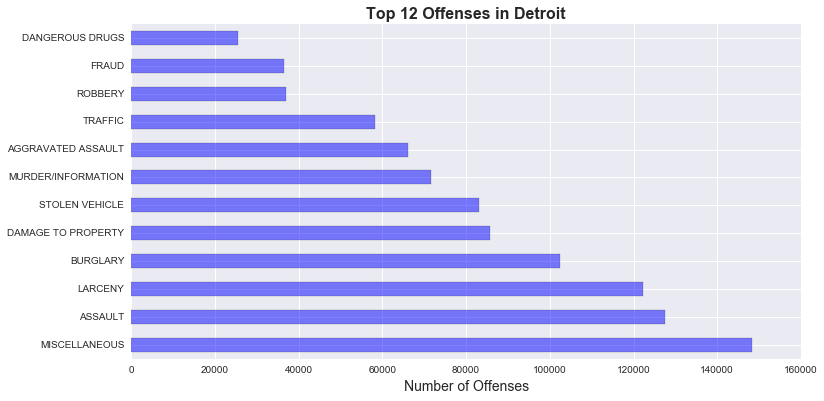

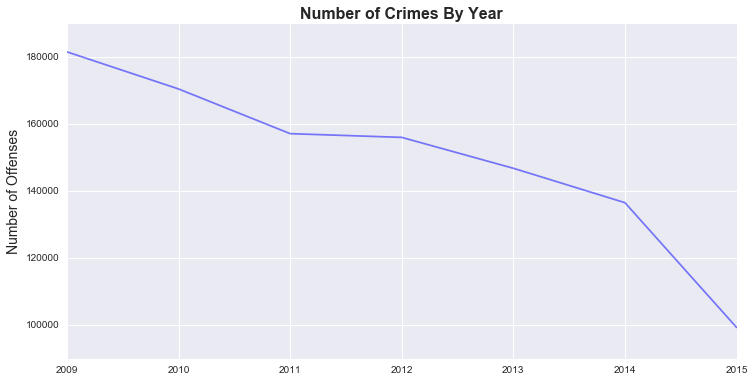

In [7]:
crime['Year'] = pd.DatetimeIndex(crime['Incident Date']).year     # Adding a column for the year of the crime

# Creating a plot of the top offenses
fig, ax = plt.subplots()                                          # Creating a figure
crime['Category'].value_counts().head(12).plot(ax=ax,             # Plotting the top 12 offenses by category (bar chart)
                                               kind='barh', 
                                               legend=False, 
                                               color='blue', 
                                               alpha=0.5,
                                               figsize=(12,6))

ax.set_xlabel('Number of Offenses', fontsize=14)                  # Label the x-axis
ax.set_title('Top 12 Offenses in Detroit',                        # Title the graph
             fontsize=16, fontweight='bold')
plt.show()

# Creating a plot of the crime trend throughout the years
fig, ax = plt.subplots()                                          # Creating a figure
crime['Year'].value_counts().plot(ax=ax,                          # Plotting the number of crimes per year (line graph)
                                  legend=False, 
                                  color='blue', 
                                  alpha=0.5,
                                  figsize=(12,6))
ax.set_ylabel('Number of Offenses', fontsize=14)                  # Label the y-axis
ax.set_title('Number of Crimes By Year',                          # Title the graph
             fontsize=16, 
             fontweight='bold')
ax.ticklabel_format(useOffset=False)                              # Make sure the years show on the x-axis
plt.show()

We can also examine the number of reported crimes in each of the largest categories over time. To do this, we must first get a count of the number of crimes in each year. We notice immediately that the number of cases of miscellaneous crimes skyrockets in 2012, while the number of murder/information crimes drops precipitously. As they seems to mirror each other, my guess is that in 2012 murder/information crimes were reclassified under miscellaneous.

Since these are not necessarily of interest as they are general categories, we will omit these and graph the top 10 offenses excluding those categories. Again we see that the number of crimes for the most common offenses has been going down (with the exception of fraud).

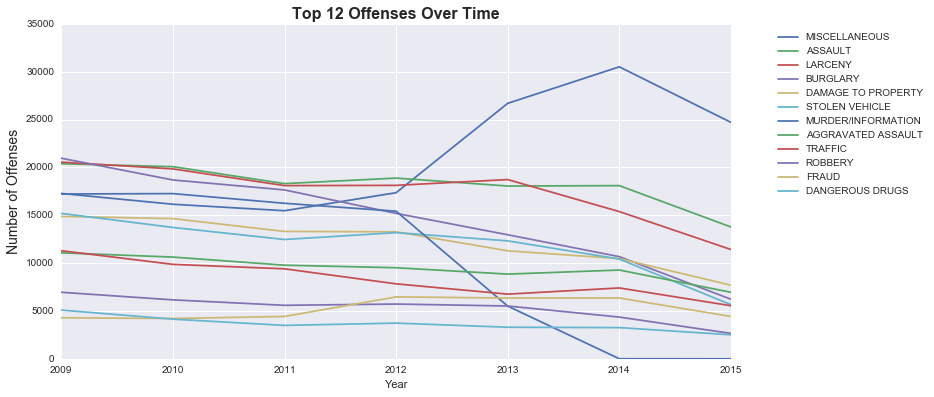

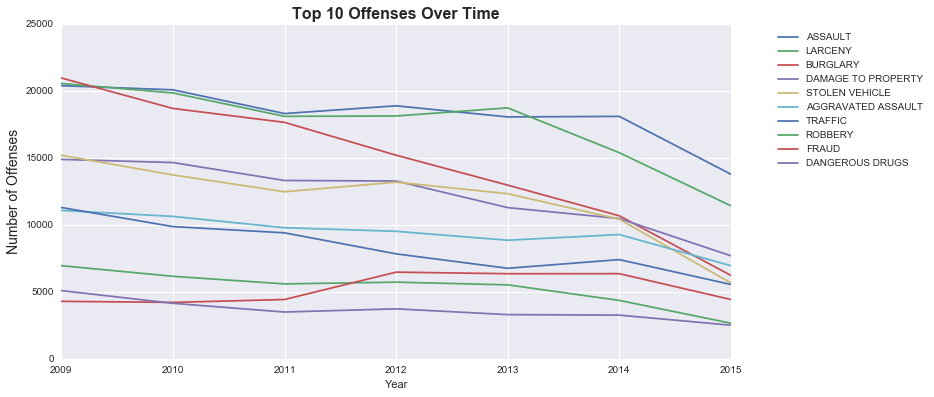

In [8]:
# Creating the pivot chart
crime.insert(0, 'Count', 1)                                # Adds a column containing a 1 for each row

crimepivot = pd.pivot_table(crime,                         # Creates a pivot table
                            index=['Year','Category'],     # for the year and category of crime
                            aggfunc=np.sum)                # by the sum of the count column created above

crimepivot = crimepivot.unstack('Category')                # Unstacks category and moves it to the top
crimepivot = crimepivot['Count'].fillna(value=0)           # Selects only the count columns & fills in NaN values with 0
top12 = crimepivot[['MISCELLANEOUS','ASSAULT','LARCENY',   # Creates a 'top12', a dataFrame containing the top 12 offenses
                   'BURGLARY','DAMAGE TO PROPERTY',        # This dataframe is now a yearly count of each offense
                   'STOLEN VEHICLE','MURDER/INFORMATION',
                   'AGGRAVATED ASSAULT','TRAFFIC',
                   'ROBBERY','FRAUD','DANGEROUS DRUGS']]

# Creates the Top 12 graph
fig, ax = plt.subplots()                                   # Creates a figure
top12.plot(ax=ax,figsize=(12,6))                           # Plots the dataframe 'top12'
ax.legend(bbox_to_anchor=(1.3, 1))                         # Moves the legend off the graph
ax.set_ylabel('Number of Offenses', fontsize=14)           # Label the y-axis
ax.set_title('Top 12 Offenses Over Time',                  # Title the graph
             fontsize=16, fontweight='bold')
ax.ticklabel_format(useOffset=False)                       # Make sure the years show on the x-axis
plt.show()

# Creates the new Top 10 graph
top10 = top12[['ASSAULT','LARCENY','BURGLARY',             # Creates a new 'top10' dataFrame
               'DAMAGE TO PROPERTY','STOLEN VEHICLE',
               'AGGRAVATED ASSAULT','TRAFFIC',
               'ROBBERY','FRAUD','DANGEROUS DRUGS']]

fig, ax = plt.subplots()                                   # Creates a figure
top10.plot(ax=ax,figsize=(12,6))                           # Plots the dataframe
ax.legend(bbox_to_anchor=(1.3, 1))                         # Moves the legend off the graph
ax.set_ylabel('Number of Offenses', fontsize=14)           # Label the y-axis
ax.set_title('Top 10 Offenses Over Time',                  # Title the graph 
             fontsize=16, fontweight='bold')
ax.ticklabel_format(useOffset=False)                       # Make sure the years show on the x-axis
plt.show()

# 3.0 Crime Examination By Time of Day

We will continue the analysis by examining the crime dataset by time of day. The obvious question with this analysis is how the number of crimes changes with the time of day. 

It appears that there have been several crimes which are documented as having happened around 12pm (there is a large spike at this time). My guess is that the crime was input into the system at a standard time of 12pm (perhaps when victims were unable to pinpoint the exact time of the crime), as suggested by [I Quant NY](http://iquantny.tumblr.com/post/142278062424/in-nyc-more-robberies-happen-right-when-school). It also appears that crimes dip to their lowest levels around 5-7am. Crimes also seems to dip a bit during dinner time (6-7pm).

It is also interesting to examine how certain offenses might be related to time of day. For this analysis, I have chosen the crime of arson. In the plot, we see that the distributions for arsons relating to private property, residences, an businesses center around early morning, while 'Arson-Public Building' centers around the hours that a public building is open. This is perhaps because the time that minor cases of arson in public buildings occur may be unknown, and perhaps might not be reported until the building opens.

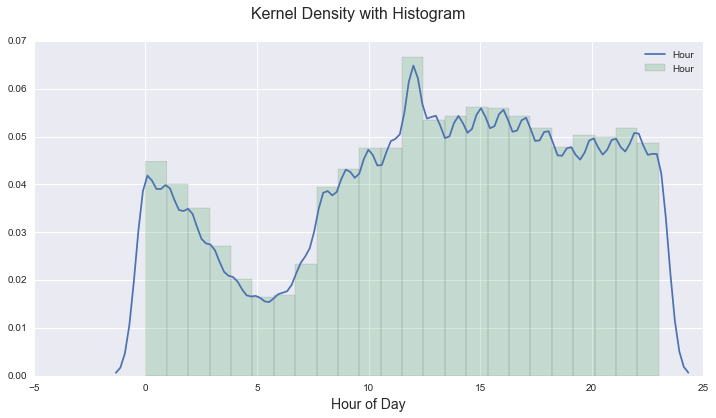

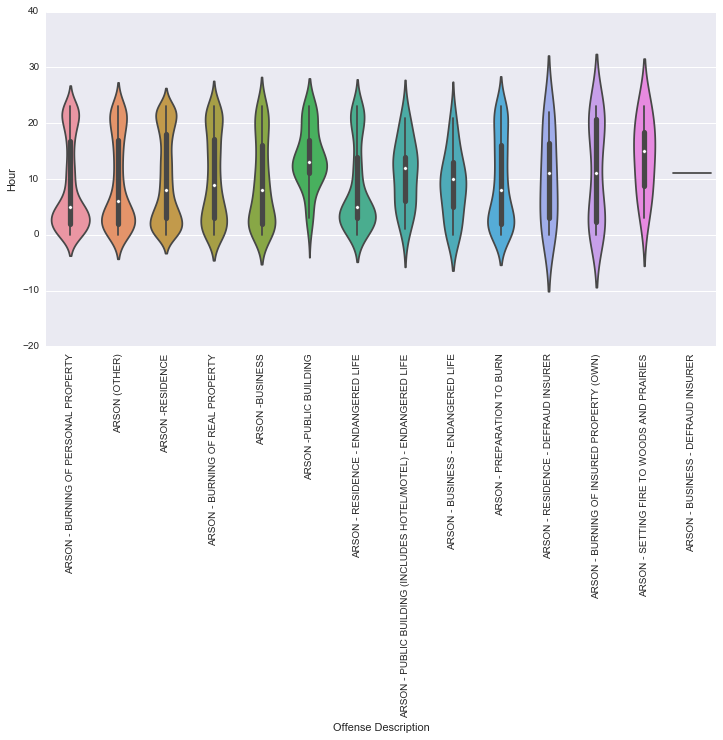

In [9]:
# Kernel Density Plot of Crime by Time of Day
sns.set()

fig, ax = plt.subplots()                               # Create a figure
fig.set_size_inches(12, 6)                             # Set figure size
sns.kdeplot(crime['Hour'], ax=ax)                      # Create a kernel density plot
ax.hist(crime['Hour'], bins=24, alpha=0.25,            # Create a histogram by hour with 24 bins
        normed=True, label='Hour')
fig.suptitle('Kernel Density with Histogram',          # Title of graph
             fontsize=16)
ax.set_xlabel('Hour of Day', fontsize = 14)            # Label x-axis
ax.legend()                                            # Add a legend
plt.show()

arson = crime['Category'] == 'ARSON'                   # Removes the arson cases from the dataFrame

# Violin plot of arsons by hour of day
fig, ax = plt.subplots()                               # Create a figure
fig.set_size_inches(12, 6)                             # Set figure size
sns.violinplot(x='Offense Description', y='Hour',      # Creates a violin plot of arson cases by hour of day
               data=crime[arson])
plt.xticks(rotation=90)                                # Rotate the axis labels so they are legible
plt.show()

# 4.0 Crime Examination By Neighborhood

We will continue the analysis by examining the difference in crimes by neighborhood. Detroit is currently the 18th largest city in the United States and has a large geographical footprint of 138.8 square miles. I have chosen to compare two neighborhoods which are very different. The first is Green Acres, which borders the city of Ferndale to the north. Ferndale is considered trendy for its nightlife. The second is the Denby which is the most dangerous according to [mLive](http://www.mlive.com/news/index.ssf/2016/02/detroits_most_dangerous_neighb.html) for containing the intersection of Kelly Rd. and Morang Ave. I was interested to see if crime has lessened in all areas of Detroit or just those that are situated near other popular areas of southeast Michigan.

We do see that instances of the top 10 crimes have remained stagnant in the time frame for Denby (dangerous), though many of the top 10 offenses have decreased in frequency for Green Acres (safe).

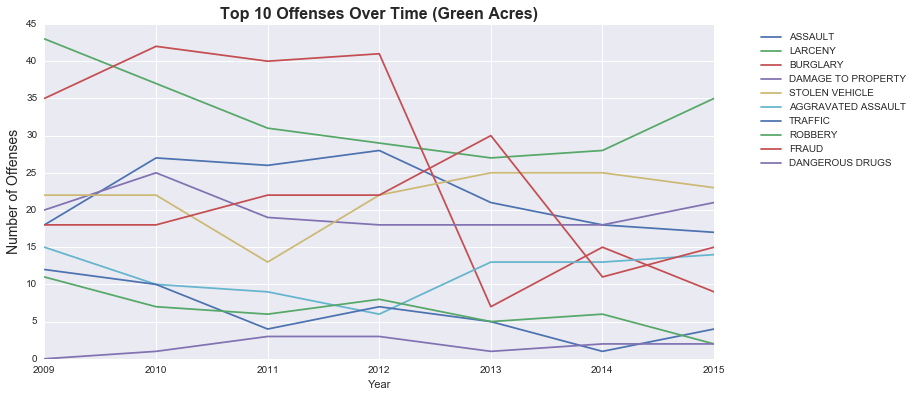

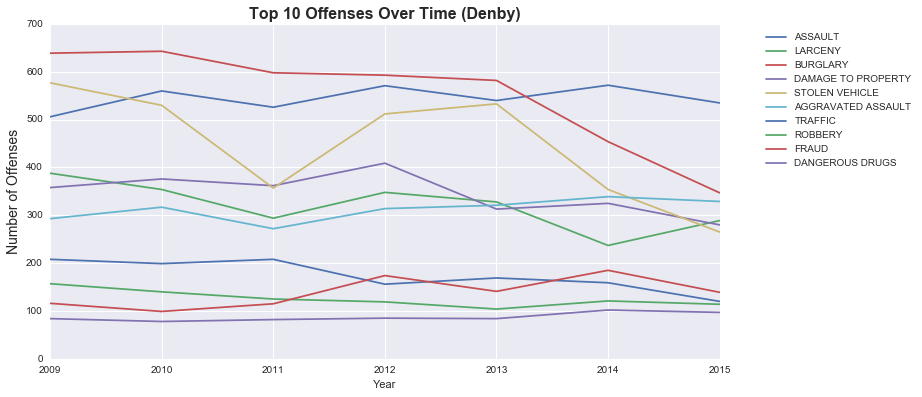

In [11]:
# Import data as before from two specific neighborhoods
url = ('https://data.detroitmi.gov/resource/i9ph-uyrp.json?'
       '&$select=caseid,address,hour,incidentdate,lat,lon,neighborhood,category,offensedescription'
       '&neighborhood=GREEN%20ACRES'
       '&$limit=100000')

greenacres = pd.read_json(url)                           # Reads in file from url in json format
greenacres = greenacres.rename(columns={'caseid':'Case ID',   # Renames the columns
                              'address':'Address',
                              'hour':'Hour',
                              'incidentdate':'Incident Date',
                              'lat':'Latitude',
                              'lon':'Longitude',
                              'neighborhood':'Neighborhood',
                              'category':'Category',
                              'offensedescription':'Offense Description'})

url = ('https://data.detroitmi.gov/resource/i9ph-uyrp.json?'
       '&$select=caseid,address,hour,incidentdate,lat,lon,neighborhood,category,offensedescription'
       '&neighborhood=DENBY'
       '&$limit=100000')

denby = pd.read_json(url)                           # Reads in file from url in json format
denby = denby.rename(columns={'caseid':'Case ID',   # Renames the columns
                              'address':'Address',
                              'hour':'Hour',
                              'incidentdate':'Incident Date',
                              'lat':'Latitude',
                              'lon':'Longitude',
                              'neighborhood':'Neighborhood',
                              'category':'Category',
                              'offensedescription':'Offense Description'})

# Add year information
greenacres['Year'] = pd.DatetimeIndex(greenacres['Incident Date']).year     # Adding a column for the year of the crime
denby['Year'] = pd.DatetimeIndex(denby['Incident Date']).year               # Adding a column for the year of the crime
greenacres.insert(0, 'Count', 1)                                            # Adds a column containing a 1 for each row
denby.insert(0, 'Count', 1)                                                 # Adds a column containing a 1 for each row
greenacres = greenacres[greenacres.Year != 2016]                            # Excludes data from 2016 (not a full year)
denby = denby[denby.Year != 2016]                                           # Excludes data from 2016 (not a full year)

# Create pivot tables for each dataset
greenacrespivot = pd.pivot_table(greenacres,                             # Creates a pivot table
                                index=['Year','Category'],               # for the year and category of crime
                                aggfunc=np.sum)                          # by the sum of the count column created above


greenacrespivot = greenacrespivot.unstack('Category')           # Unstacks category and moves it to the top
greenacrespivot = greenacrespivot['Count'].fillna(value=0)      # Selects only the count columns & fills in NaN values with 0
greenacrestop10 = greenacrespivot[['ASSAULT','LARCENY',         # Selects the top 10 Detroit crimes
                                   'BURGLARY',
                                   'DAMAGE TO PROPERTY',
                                   'STOLEN VEHICLE',
                                   'AGGRAVATED ASSAULT',
                                   'TRAFFIC',
                                   'ROBBERY','FRAUD',
                                   'DANGEROUS DRUGS']]


denbypivot = pd.pivot_table(denby,                                      # Creates a pivot table
                            index=['Year','Category'],                  # for the year and category of crime
                            aggfunc=np.sum)                             # by the sum of the count column created above

denbypivot = denbypivot.unstack('Category')                      # Unstacks category and moves it to the top
denbypivot = denbypivot['Count'].fillna(value=0)                 # Selects only the count columns & fills in NaN values with 0
denbytop10 = denbypivot[['ASSAULT','LARCENY','BURGLARY',         # Selects the top 10 Detroit crimes
                         'DAMAGE TO PROPERTY','STOLEN VEHICLE',
                         'AGGRAVATED ASSAULT','TRAFFIC',
                         'ROBBERY','FRAUD','DANGEROUS DRUGS']]

# Creates a Top 10 graph for Pembroke
fig, ax = plt.subplots()                                   # Creates a figure
greenacrestop10.plot(ax=ax,figsize=(12,6))                   # Plots the dataframe
ax.legend(bbox_to_anchor=(1.3, 1))                         # Moves the legend off the graph
ax.set_ylabel('Number of Offenses', fontsize=14)           # Label the y-axis
ax.set_title('Top 10 Offenses Over Time (Green Acres)',       # Title the graph 
             fontsize=16, fontweight='bold')
ax.ticklabel_format(useOffset=False)                       # Make sure the years show on the x-axis
plt.show()

# Creates a Top 10 graph for Denby
fig, ax = plt.subplots()                                   # Creates a figure
denbytop10.plot(ax=ax,figsize=(12,6))                      # Plots the dataframe
ax.legend(bbox_to_anchor=(1.3, 1))                         # Moves the legend off the graph
ax.set_ylabel('Number of Offenses', fontsize=14)           # Label the y-axis
ax.set_title('Top 10 Offenses Over Time (Denby)',          # Title the graph 
             fontsize=16, fontweight='bold')
ax.ticklabel_format(useOffset=False)                       # Make sure the years show on the x-axis
plt.show()

# 5.0 Crime Examination By Proximity to Institutions

We will conclude the analysis by performing a locational analysis on the arson subset to examine how far away the different types of arson occur from different institutions (police stations, fire stations, schools). I have chosen arson because arsons often deal with buildings.

My hypothesis was that the distribution of crime location in relation to institutions such as police stations, fire stations, and schools would not be normal and would depend on the type of crime. We see that the distributions of proximity to institution  have long right tails for police stations and fire stations, meaning the distributions are not normal. For schools, the distribution does not favor a right or left tail. One reason this may be is because there are many more schools than there are other institutions, which tightens the distance to the nearest schools. Crimes may not be affected by the closeness to a school in the same way they appear to be affected by closeness to a police station or fire station.

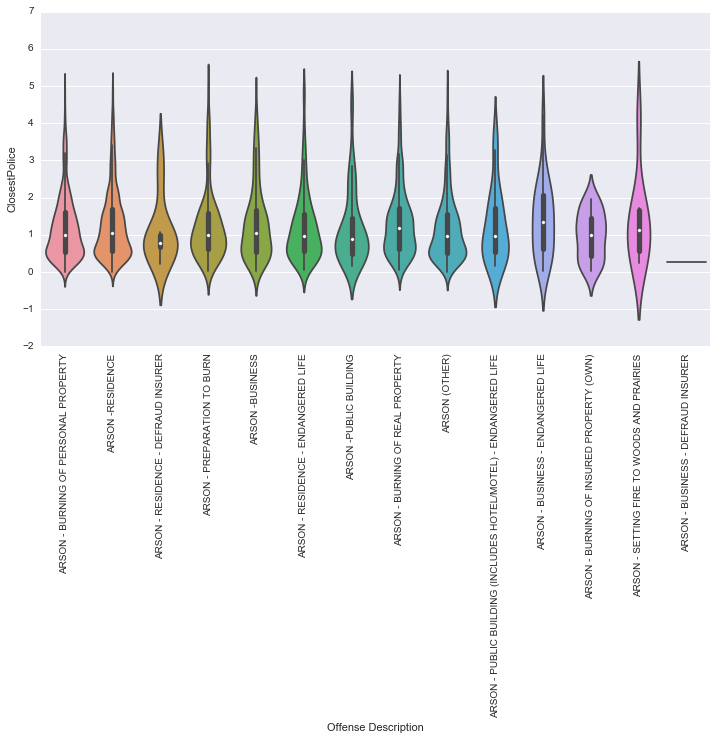

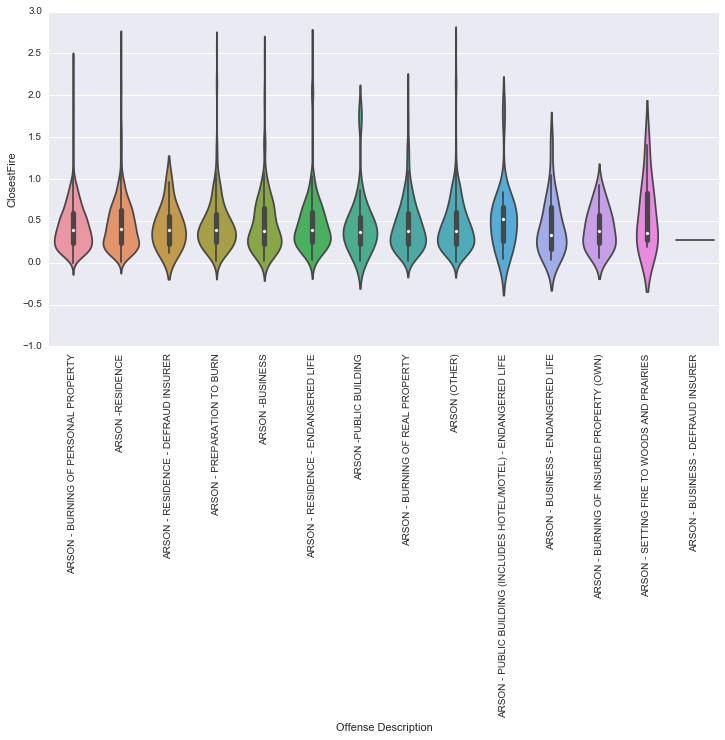

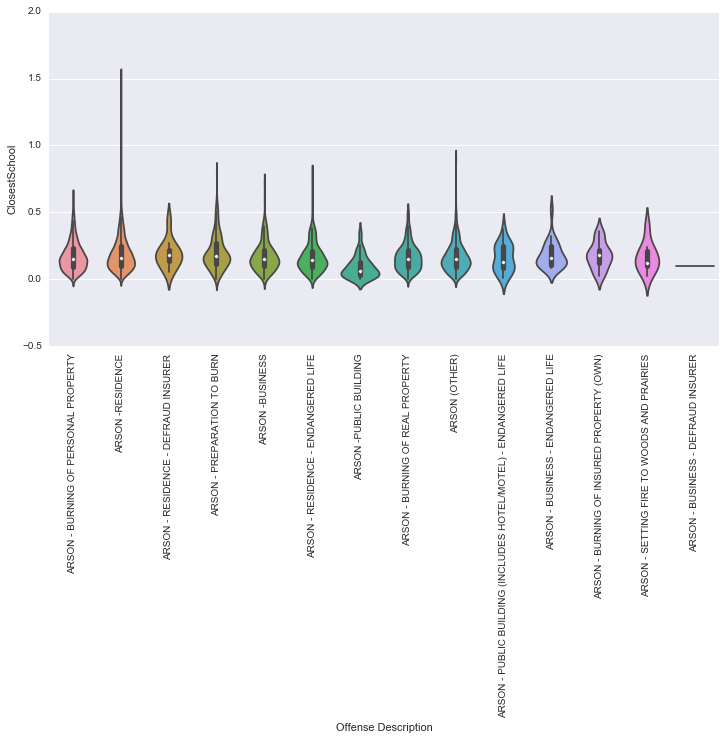

In [12]:
# Violin plots of the closeness of different types of arson offenses
# to police stations, fire stations, and schools

url = ('https://data.detroitmi.gov/resource/i9ph-uyrp.json?'
       '&$select=caseid,address,hour,incidentdate,lat,lon,neighborhood,category,offensedescription'
       '&category=ARSON'
       '&$limit=10000')

arson = pd.read_json(url)                           # Reads in file from url in json format
arson = arson.rename(columns={'caseid':'Case ID',   # Renames the columns
                              'address':'Address',
                              'hour':'Hour',
                              'incidentdate':'Incident Date',
                              'lat':'Latitude',
                              'lon':'Longitude',
                              'neighborhood':'Neighborhood',
                              'category':'Category',
                              'offensedescription':'Offense Description'})

arson.insert(0, 'ClosestPolice', 0.0)                        # Inserts a column with float values for closest police station
arson.insert(1, 'ClosestFire', 0.0)                          # Inserts a column with float values for closest fire station
arson.insert(2, 'ClosestSchool', 0.0)                        # Inserts a column with float values for closest school

from geopy.distance import vincenty                          # Imports a package for calculating distance from coordinates

# This code goes through each row and compares the location of the crime to
# each of the police stations and finds the smallest distance between the two.
for (ic, c) in arson.iterrows():                             # Iterates through the rows (crimes) of the arson dataFrame
    dist = 100000000.0                                       # Starts with a distance of a large number (float)
    coord_crime = (c['Longitude'], c['Latitude'])            # Creates a variable containing the crime coordinates
    for (ips, ps) in police.iterrows():                      # Iterates through the rows (locations) of the police dataFrame
        coord_ps = (ps['Longitude'], ps['Latitude'])         # Creates a variable containing the police station coordinates
        currdist = vincenty(coord_crime, coord_ps).miles     # Calculates the distance between a crime and a police station
        if currdist < dist:                                  # If the distance between the two is smaller than previous
            dist = currdist                                  # stations, the new distance will be used
    arson.set_value(ic, 'ClosestPolice', dist)               # Once done with the police stations, the cell is filled with
                                                             # the distance (in miles) of the closest police station

# This code goes through each row and compares the location of the crime to
# each of the fire stations and finds the smallest distance between the two.        
for (ic, c) in arson.iterrows():                             # Iterates through the rows (crimes) of the arson dataFrame
    dist = 100000000.0                                       # Starts with a distance of a large number (float)
    coord_crime = (c['Longitude'], c['Latitude'])            # Creates a variable containing the crime coordinates
    for (ifs, fs) in fire.iterrows():                        # Iterates through the rows (locations) of the fire dataFrame
        coord_fs = (fs['Longitude'], fs['Latitude'])         # Creates a variable containing the fire station coordinates
        currdist = vincenty(coord_crime, coord_fs).miles     # Calculates the distance between a crime and a fire station
        if currdist < dist:                                  # If the distance between the two is smaller than previous
            dist = currdist                                  # stations, the new distance will be used
    arson.set_value(ic, 'ClosestFire', dist)                 # Once done with the fire stations, the cell is filled with
                                                             # the distance (in miles) of the closest fire station
    
# This code goes through each row and compares the location of the crime to
# each of the schools and finds the smallest distance between the two. 
for (ic, c) in arson.iterrows():                             # Iterates through the rows (crimes) of the arson dataFrame
    dist = 100000000.0                                       # Starts with a distance of a large number (float)
    coord_crime = (c['Longitude'], c['Latitude'])            # Creates a variable containing the crime coordinates
    for (isch, sch) in school.iterrows():                    # Iterates through the rows (locations) of the school dataFrame
        coord_sch = (sch['Longitude'], sch['Latitude'])      # Creates a variable containing the school coordinates
        currdist = vincenty(coord_crime, coord_sch).miles    # Calculates the distance between a crime and a school
        if currdist < dist:                                  # If the distance between the two is smaller than previous
            dist = currdist                                  # stations, the new distance will be used
    arson.set_value(ic, 'ClosestSchool', dist)               # Once done with the schools, the cell is filled with
                                                             # the distance (in miles) of the closest school

# Filters out bad data    
arson = arson[arson.ClosestPolice < 5]                       # Filters out distances more than 5 miles (errors)
arson = arson[arson.ClosestPolice > 0]                       # Filters out distances of zero (errors)
arson = arson[arson.ClosestFire < 5]                         # Filters out distances more than 5 miles (errors)
arson = arson[arson.ClosestFire > 0]                         # Filters out distances of zero (errors)
arson = arson[arson.ClosestSchool < 5]                       # Filters out distances more than 5 miles (errors)
arson = arson[arson.ClosestSchool > 0]                       # Filters out distances of zero (errors)

# Creates a violin plot of type of arson vs. closest police station
fig, ax = plt.subplots()                                     # Creates a figure
fig.set_size_inches(12, 6)                                   # Sizes the figure
sns.violinplot(x='Offense Description', y='ClosestPolice',   # Creates a violinplot of type of offense versus distance
               data=arson)                                   # between the crime and the closest police station
plt.xticks(rotation=90)                                      # Rotates the labels so they are readable
plt.show()

# Creates a violin plot of type of arson vs. closest fire station
fig, ax = plt.subplots()                                     # Creates a figure
fig.set_size_inches(12, 6)                                   # Sizes the figure
sns.violinplot(x='Offense Description', y='ClosestFire',     # Creates a violinplot of type of offense versus distance
               data=arson)                                   # between the crime and the closest fire station
plt.xticks(rotation=90)                                      # Rotates the labels so they are readable
plt.show()

# Creates a violin plot of type of arson vs. closest school
fig, ax = plt.subplots()                                     # Creates a figure
fig.set_size_inches(12, 6)                                   # Sizes the figure
sns.violinplot(x='Offense Description', y='ClosestSchool',   # Creates a violinplot of type of offense versus distance
               data=arson)                                   # between the crime and the closest school
plt.xticks(rotation=90)                                      # Rotates the labels so they are readable
plt.show()

One other possible examination is the number of crimes versus proximity to an institution, taking into account the hour of day. This analysis does not show any interesting distributions, though the plots look nice.

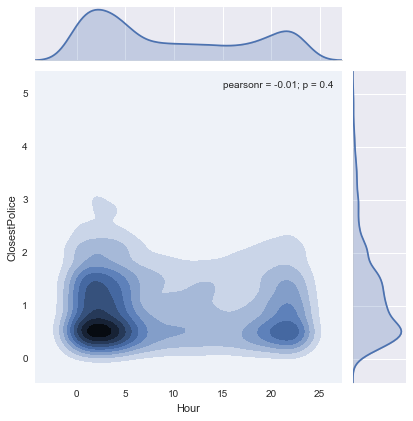

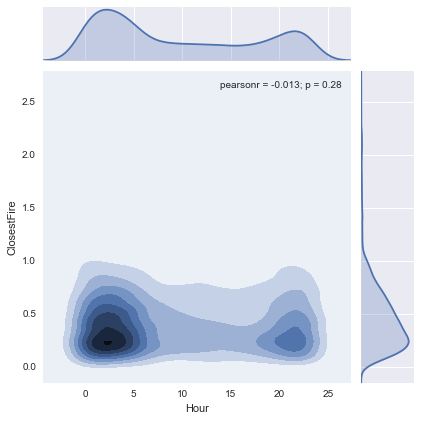

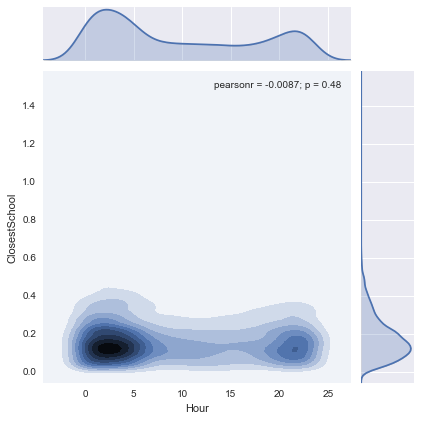

In [13]:
# Jointplots of Hour of Day vs. Closest Institution (number of crimes is density)
sns.jointplot(x='Hour', y='ClosestPolice', data=arson, kind='kde')
sns.jointplot(x='Hour', y='ClosestFire', data=arson, kind='kde')
sns.jointplot(x='Hour', y='ClosestSchool', data=arson, kind='kde')

# 6.0 Conclusion

We were able to show that the overall number of crimes in Detroit have been decreasing in recent years, though this reduction may favor the "nicer" neighborhoods over the ones which have traditionally been more dangerous. Crimes are much more likely to happen in the middle of the day and at night than they are in the early morning. For arsons specifically, the distribution of time of day depends on the specific crime. These crimes may occur further from police and fire stations, though the proximity to schools does not appear to affect the crime location.

# 7.0 Further Study

This code is freely available to anyone to adapt as they see fit. My recommendations for further study include an examination of pre-Great Recession Detroit crime data, which I am unable to locate, as well as similar analysis of crime data for other large cities in the United States. It might also be useful to compare crime across demographics such as median household income, as well as demographics of the alleged criminal, if this data is available. 

One interesting topic of study might be the unemployment rate versus crime levels over time. The period of available data overlaps with the end of the Great Recession, which hit Detroit very hard. According to the Bureau of Labor Statistics, the unemployment rate (not seasonally adjusted) in Detroit peaked at 28.4% in June 2009. There has been significant study regarding crime reduction across the United States during the Great Recession, so it would be interesting to find out if the Detroit Crime Data reflects this. One question might examine if there is a lag of some kind between unemployment rate and crime levels, perhaps after the period when new unemployment claims expire.

# 8.0 Data Sources & Acknowledgement

The datasets are accessed live from [Detroit Open Data](https://data.detroitmi.gov/) in the json format.

I would like to thank Professor [David Backus](http://www.stern.nyu.edu/faculty/bio/david-backus), and PhD Candidate Chase Coleman, both of the New York University Leonard N. Stern School of Business Department of Economics, for their assistance with this project.